In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from sklearn.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
stu_19 = pd.read_csv('../data/summary_student.csv')

In [3]:
stu_19.head(2)

,dbn,school_name,student_response_rate,1a,1b,1c,1d,1e,1f,1g,...,8b,8c,8d,8e,8f,8g,8h,9a,9b,combined_mean_score
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,95.0,17.31,20.33,13.86,14.69,30.21,26.27,19.69,...,2.62,2.50,2.68,2.46,2.76,1.73,1.80,3.11,3.16,587.928579
1,01M140,P.S. 140 NATHAN STRAUS,87.0,16.22,13.52,11.91,12.06,25.48,18.44,18.73,...,2.34,2.13,2.41,2.67,2.67,1.47,1.81,3.16,3.18,589.583906


In [4]:
# I will be using adjusted R2 later, so I will make a function now.
def adj_r2(y_true, y_preds, features):
    '''Calculates the adjusted R2 score from y_true, y_preds, and the  number of features.
    This function uses the r2_score function from sklearn.
    '''
    n = len(y_true)
    true_mean = np.mean(y_true)
    r2 = r2_score(y_true, y_preds)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - features - 1)
    return adj_r2

In [5]:
# Instantiate X
X = stu_19.iloc[:, 3:-1]
y = stu_19['combined_mean_score']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

In [7]:
# null model
null = DummyRegressor()
null.fit(X_train, y_train)
null_score = null.score(X_test, y_test)
null_preds = null.predict(X_test)
null_adj_r2 = adj_r2(y_test, null_preds, len(X.columns))
null_mse = mean_squared_error(y_test, null_preds)

scores = pd.DataFrame({'model': 'null', 'r2': null_score, 'adjusted_r2': null_adj_r2, 'mse': null_mse}, index=[0])

In [8]:
# There are a lot of collinearity among features, but I want to see what the performance of a linear model with all features

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
# cross validation
cross_val_score(lr, X_train, y_train)

array([0.75852848, 0.76051448, 0.81951115, 0.78143553, 0.71763426])

In [10]:
lr_score = lr.score(X_test, y_test)

This is a pretty high R2 score, but I am using all features (58 of them), so I need to calculate the adjusted R2

In [11]:
preds = lr.predict(X_test)

In [12]:
# calculate adjusted R2
r2_adj = adj_r2(y_test, preds, len(X_train.columns))
r2_adj

0.622971680717458

In [13]:
# calculate mean squared error
mse = mean_squared_error(y_test, preds)
mse

27.075655309245082

In [14]:
scores_d = {'model': 'linear_all', 'r2': lr_score, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

It still looks like the student survey responses do have some predictive power. I'm going to verify with PCA before I tackle the collinearity in depth for an interpretable model

In [15]:
# PCA should help with the collinearity issue

# scale data first
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train, y_train)
X_test_ss = ss.transform(X_test)

pca = PCA()
pca.fit(X_train_ss)

PCA()

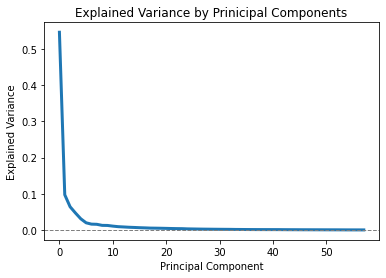

In [16]:
# plot the explanined variance
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')
# plt.plot(range(len(cum_var_exp)), cum_var_exp, label = 'Cumulative Variance Explained')
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.title('Explained Variance by Prinicipal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance');

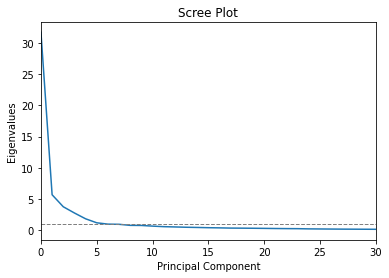

In [17]:
# make a scree plot
eigenvals = pca.explained_variance_

plt.plot(eigenvals)

plt.xlabel('Principal Component')
plt.ylabel('Eigenvalues')
plt.title('Scree Plot')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')
plt.xlim(0, 30);

In [18]:
# setup pipeline with PCA and linear regression
pipe = make_pipeline(PCA(), LinearRegression())

params = {'pca__n_components': [2, 5, 6, 10]} 

grid = GridSearchCV(pipe, param_grid=params, cv=10)

grid.fit(X_train_ss, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'pca__n_components': [2, 5, 6, 10]})

In [19]:
grid.best_params_

{'pca__n_components': 10}

In [20]:
pca_lr_score = grid.score(X_test_ss, y_test)
pca_lr_score

0.7045743444897573

In [21]:
grid.score(X_train_ss, y_train)

0.700593475676009

In [22]:
predictions = grid.predict(X_test_ss)

In [23]:
r2_adj = adj_r2(y_test, predictions, 10)
r2_adj

0.6777174667160988

In [24]:
mse = mean_squared_error(y_test, predictions)
mse

41.06225247084549

In [25]:
scores_d = {'model': 'pca_linear', 'r2': pca_lr_score, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

In [26]:
pca.inverse_transform(X_train_ss)

array([[-0.35764505, -0.05400063,  0.05926097, ...,  0.79500897,
         0.37847716, -0.44737328],
       [ 0.58389566,  0.12194332, -0.61299937, ..., -0.97897598,
         0.40664495, -0.72552052],
       [ 0.13957902, -0.38893243,  0.85841979, ..., -1.25135261,
        -0.75056906, -0.64177341],
       ...,
       [ 0.02465718,  1.00419289,  0.12803381, ...,  0.88424677,
         0.7867966 , -0.09921965],
       [ 0.27308311, -0.82871624, -0.14016944, ..., -0.75101502,
        -0.39604605, -0.44731047],
       [-0.71294949,  1.58759966,  0.81841982, ...,  0.2450022 ,
        -1.28412618, -0.00900601]])

### Feature Selection
In order to reduce the number of features, I will be doing a few things. First, I will remove a few questions that are addressing the same topics first.

In [27]:
# Questions 8b-e will be dropped. 8a can address all the other questions. Questions 9a and 9b can be addressed by just 9b.
stu_19.drop(columns=['8b', '8c', '8d', '8e', '9a'], inplace=True)

In [28]:
from sklearn.cross_decomposition import PLSRegression # available on dev version

In [29]:
X = stu_19.iloc[:, 3:-1]
Y = stu_19[['combined_mean_score']]

In [30]:
X.head()

,1a,1b,1c,1d,1e,1f,1g,1h,1i,1j,...,6i,7a,7b,7c,7d,8a,8f,8g,8h,9b
0,17.31,20.33,13.86,14.69,30.21,26.27,19.69,14.71,18.71,21.33,...,2.94,2.97,3.09,2.92,3.10,2.89,2.76,1.73,1.80,3.16
1,16.22,13.52,11.91,12.06,25.48,18.44,18.73,10.06,10.10,15.47,...,2.92,2.82,3.03,3.01,3.04,2.73,2.67,1.47,1.81,3.18
2,12.47,18.27,15.32,14.14,36.05,22.33,15.70,12.01,14.93,16.53,...,3.00,2.90,2.98,3.09,3.27,2.58,2.37,1.34,1.64,3.09
3,3.93,3.87,3.92,3.87,3.92,3.89,3.89,3.91,3.91,3.89,...,3.60,3.63,3.48,3.84,3.77,1.28,1.50,1.12,1.10,3.87
4,11.78,16.62,15.19,10.10,23.72,17.65,10.06,14.85,19.71,19.35,...,2.79,3.04,3.14,2.95,3.08,2.67,2.70,1.34,1.47,3.20


In [31]:
Y.head()

,combined_mean_score
0,587.928579
1,589.583906
2,615.871862
3,595.348350
4,589.192540


In [32]:
pls5 = PLSRegression(n_components=5)
pls5.fit(X, Y)

PLSRegression(n_components=5)

In [33]:
pls5.get_params()

{'copy': True, 'max_iter': 500, 'n_components': 5, 'scale': True, 'tol': 1e-06}

In [34]:
pls5.score(X, Y)

0.8039895864344707

In [35]:
X = stu_19.iloc[:, 3:-1]
y = stu_19['combined_mean_score']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

In [37]:
X_train.shape, X_test.shape

((361, 53), (121, 53))

In [38]:
null = DummyRegressor()
null.fit(X_train, y_train)
null.score(X_test, y_test)

-0.01270516140431699

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [40]:
cross_val_score(lr, X_train, y_train)

array([0.72731143, 0.73726497, 0.76629051, 0.79599076, 0.82185966])

In [41]:
np.mean(cross_val_score(lr, X_train, y_train))

0.7697434664585432

In [42]:
lr.score(X_train, y_train)

0.8499197212069052

In [43]:
linear_reduced = lr.score(X_test, y_test)
linear_reduced

0.7945335144537562

In [44]:
preds = lr.predict(X_test)

In [45]:
r2_adj = adj_r2(y_test, preds, len(X_test.columns))
r2_adj

0.6320003243947871

In [46]:
mse = mean_squared_error(y_test, preds)
mse

22.398451759226774

In [47]:
scores_d = {'model': 'linear_reduced', 'r2': linear_reduced, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

In [48]:
lr.coef_

array([ -0.08842259,   0.13328664,   0.10123907,  -0.11625008,
         0.10667826,   0.10359663,  -0.12385575,  -0.03741006,
         0.033273  ,  -0.14262055,  -0.20836372,  -4.33820223,
        -5.23184875,   0.93696247,   7.55267229,  15.63072507,
         6.51735286,   3.73865039, -16.69949039,  -9.2605119 ,
        -4.7370611 ,  -3.72924353,  -5.44676773, -11.90098459,
       -13.45243615,   9.24198044,  -1.31177346,  18.64109989,
         2.60234292,  -0.32270511,  -4.11428686,  -9.15109346,
         9.53488811,   1.83966452,  -7.47520429,  -1.43406069,
        13.2923918 ,  -0.68670349,   7.14739839,   3.30471794,
         8.17986006, -23.08494517,  -2.36385355,   2.79086691,
        -6.39585577,   8.62692903,  -7.98300569,  30.14371583,
         8.85228233,  -7.20660073,   2.16163563,  -6.4745732 ,
        -2.33856445])

In [49]:
# use stats model to get a better idea of the coefficients
X_train = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_train)
results = ols.fit()

In [50]:
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     combined_mean_score   R-squared:                       0.850
Model:                             OLS   Adj. R-squared:                  0.824
Method:                  Least Squares   F-statistic:                     32.80
Date:                 Tue, 17 Nov 2020   Prob (F-statistic):           3.42e-98
Time:                         09:48:06   Log-Likelihood:                -1019.6
No. Observations:                  361   AIC:                             2147.
Df Residuals:                      307   BIC:                             2357.
Df Model:                           53                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        571.9027     14.685     38.94

In [51]:
# from https://stackoverflow.com/questions/47388258/how-to-extract-the-regression-coefficient-from-statsmodels-api
df = pd.read_html(results.summary().tables[1].as_html(),header=0,index_col=0)[0]

In [52]:
df.head(2)

,coef,std err,t,P>|t|,[0.025,0.975]
const,571.9027,14.685,38.943,0.000,543.006,600.800
1a,-0.0884,0.122,-0.723,0.471,-0.329,0.152


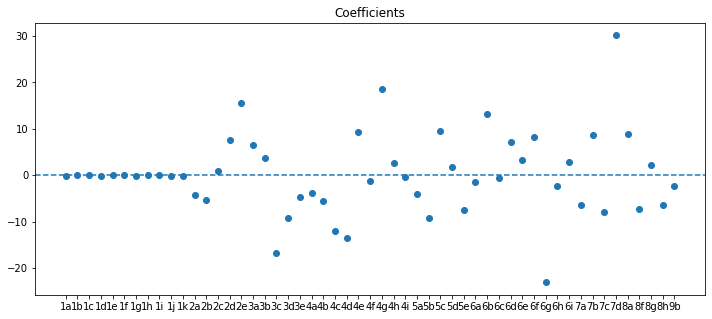

In [53]:
coefs = df.loc['1a':, 'coef']
plt.figure(figsize=(12, 5))
plt.plot(coefs, 'o')
plt.axhline(y=0, ls='--')
plt.title('Coefficients');

In [54]:
coefs = coefs.sort_values(ascending=False)[:10]

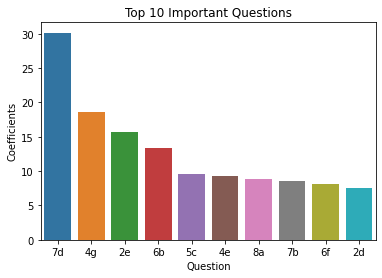

In [55]:
coefs = pd.DataFrame(coefs, columns=['coef'])
sns.barplot(x=coefs.index, y=coefs['coef'])
plt.title('Top 10 Important Questions')
plt.ylabel('Coefficients')
plt.xlabel('Question')
plt.savefig('../assets/top10_important_questions.png', bbox_inches='tight');

In [56]:
# do a ridge model to see if I can decifer something

# first scale data
ss = StandardScaler()
X_train = X_train.drop(columns=['const'])
X_train_ss = ss.fit_transform(X_train, y_train)
X_test_ss = ss.transform(X_test)

# ridgecv
ridgecv = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100))
ridgecv.fit(X_train_ss, y_train)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]))

In [57]:
ridgecv.alpha_

10.0

In [58]:
ridge_coefs = ridgecv.coef_

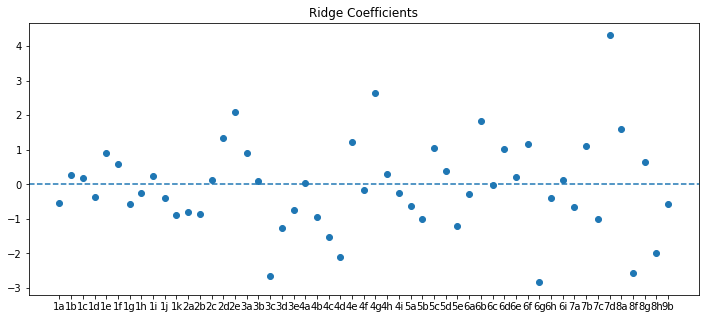

In [59]:
plt.figure(figsize=(12, 5))
plt.plot(df.index[1:], ridge_coefs, 'o')
plt.axhline(y=0, ls='--')
plt.title('Ridge Coefficients');

In [60]:
cross_val_score(ridgecv, X_train, y_train)

array([0.73243844, 0.75323143, 0.76617101, 0.79974492, 0.82500539])

In [61]:
ridge_score = ridgecv.score(X_test_ss, y_test)
ridge_score

0.7966557571142232

In [62]:
preds = ridgecv.predict(X_test_ss)

In [63]:
r2_adj = adj_r2(y_test, preds, len(X_test.columns))
r2_adj

0.6358013560254744

In [64]:
mse = mean_squared_error(y_test, preds)
mse

22.167100404160436

In [65]:
scores_d = {'model': 'ridge', 'r2': ridge_score, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

In [66]:
coefs = pd.DataFrame(ridge_coefs, df.index[1:])
coefs.columns = ['coefs']

In [67]:
coefs.sort_values(by='coefs', ascending=False)

,coefs
7d,4.316199
4g,2.657815
2e,2.104479
6b,1.832048
8a,1.608968
2d,1.332623
4e,1.214853
6f,1.177127
7b,1.097912
5c,1.061895


In [68]:
# I want to see what happens when I use only the top 3 questons

In [69]:
top3 = stu_19[['7d', '4g', '2e', 'combined_mean_score']]

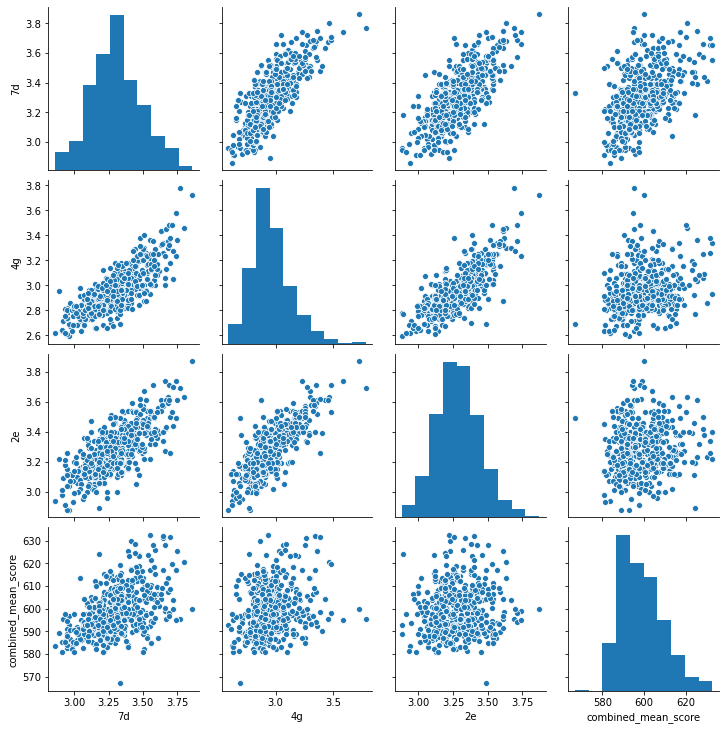

In [70]:
sns.pairplot(top3);

In [71]:
X = top3.iloc[:, :-1]
y = top3[['combined_mean_score']]
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [72]:
# the questions are all collinear with each other, but I will check out how much these have in predicting 
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [73]:
cross_val_score(lr, X_train, y_train)

array([0.38451144, 0.38331794, 0.32793807, 0.41856629, 0.49135617])

In [74]:
top3_score = lr.score(X_test, y_test)
top3_score

0.3757666240890173

In [75]:
preds = lr.predict(X_test)
mse = mean_squared_error(y_test, preds)
mse

75.96556501571999

In [76]:
r2_adj = adj_r2(y_test, preds, len(X.columns))
r2_adj

0.3597606400912998

In [77]:
scores_d = {'model': 'top3_linear', 'r2': top3_score, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

These 3 questions have pretty strong predictive power with R2 of around 0.36. Let me start adding more features with this. Before I do that, I want to see indivial contribution within a linear model. 

In [78]:
# look at question 7d. 'I feel safe in my classes at this school.'
X7 = stu_19[['7d']]
y = stu_19['combined_mean_score']

# train test split
X7_train, X7_test, y_train, y_test = train_test_split(X7, y, random_state=77)

# model
lr_7d = LinearRegression()
lr_7d.fit(X7_train, y_train)

LinearRegression()

In [79]:
cross_val_score(lr_7d, X7_train, y_train)

array([0.25325876, 0.19497905, 0.21518846, 0.26292154, 0.2325077 ])

In [80]:
lr_7d.score(X7_test, y_test)

0.242164578748704

In [81]:
lr_7d.intercept_

508.5171131191498

In [82]:
lr_7d.coef_

array([27.36098184])

A little less than a quarter of the predictions are explained by this one question. 

In [83]:
# look at question 4g. 'My classes at this school really make me think critically.'
X4 = stu_19[['4g']]
y = stu_19['combined_mean_score']

# train test split
X4_train, X4_test, y_train, y_test = train_test_split(X4, y, random_state=77)

# model
lr_4 = LinearRegression()
lr_4.fit(X4_train, y_train)

LinearRegression()

In [84]:
cross_val_score(lr_4, X4_train, y_train)

array([0.05073491, 0.0131549 , 0.05070348, 0.06149044, 0.03324041])

In [85]:
lr_4.score(X4_test, y_test)

0.09321760523660283

Question 4d alone does not have much of a predictive power compared here.

In [86]:
# look at question 2e. 'I know what my teacher wants me to learn in class.'
X2 = stu_19[['2e']]
y = stu_19['combined_mean_score']

# train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=77)

# model
lr_2 = LinearRegression()
lr_2.fit(X2_train, y_train)

LinearRegression()

In [87]:
cross_val_score(lr_2, X2_train, y_train)

array([ 0.00623215,  0.00313522, -0.01407242,  0.00504959,  0.01620767])

Neighter question 4g nor 2e alone is really driving the prediction on student scores.

### Feature selection with SelectKBest

In [88]:
X = stu_19.iloc[:, 3:-1]
y = stu_19['combined_mean_score']

In [89]:
kbest = SelectKBest(f_regression, k=10)
X_new = kbest.fit_transform(X, y)

In [90]:
X_new.shape

(482, 10)

In [91]:
# which columns?
best10_cols = X.columns[kbest.get_support()]
best10_cols

Index(['1a', '1g', '1h', '7a', '7b', '7c', '7d', '8a', '8f', '8h'], dtype='object')

In [92]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, random_state=77)

In [93]:
lr_kbest = LinearRegression()
lr_kbest.fit(X_train, y_train)

LinearRegression()

In [94]:
cross_val_score(lr_kbest, X_train, y_train)

array([0.56817567, 0.57361272, 0.543785  , 0.56137906, 0.5984883 ])

In [95]:
kbest10_score = lr_kbest.score(X_test, y_test)
kbest10_score

0.5669710837624804

In [96]:
# repeat with top 5 features
kbest5 = SelectKBest(f_regression, k=5)
X_new5 = kbest5.fit_transform(X, y)

In [97]:
# which columns
X.columns[kbest5.get_support()]

Index(['1a', '7a', '7d', '8f', '8h'], dtype='object')

In [98]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_new5, y, random_state=77)

In [99]:
lr_kbest5 = LinearRegression()
lr_kbest5.fit(X_train, y_train)

LinearRegression()

In [100]:
cross_val_score(lr_kbest5, X_train, y_train)

array([0.42948654, 0.35768099, 0.49526396, 0.42089611, 0.3478259 ])

In [101]:
lr_kbest5.score(X_test, y_test)

0.4715432507215672

### Selecting questions related to how the students perceive safety at school
So far many of models are pointing to students perceiving how safe they feel at school are important factors in predicting students test scores. Here, I will test whether these factors alone can have a pretty high predictive power.

In [102]:
# questions related to safety are 7s and 8s
X_safe = X[[column for column in X.columns if (column.startswith('7')) | (column.startswith('8'))]]

In [103]:
X_safe.head(2)

,7a,7b,7c,7d,8a,8f,8g,8h
0,2.97,3.09,2.92,3.10,2.89,2.76,1.73,1.80
1,2.82,3.03,3.01,3.04,2.73,2.67,1.47,1.81


In [104]:
X_safe.shape

(482, 8)

In [105]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_safe, y, random_state=77)

# fit to a linear model
lr_safe = LinearRegression()
lr_safe.fit(X_train, y_train)

LinearRegression()

In [106]:
# cross validate
cross_val_score(lr_safe, X_train, y_train)

array([0.61253046, 0.62632586, 0.59047245, 0.58696405, 0.63805881])

In [107]:
lr_safe.score(X_train, y_train)

0.6360655020838875

In [108]:
# R2 score
safe_lr_score = lr_safe.score(X_test, y_test)
safe_lr_score

0.5735614691534445

In [109]:
# predictions
safe_preds = lr_safe.predict(X_test)

In [110]:
# adjusted R2
r2_adj = adj_r2(y_test, safe_preds, 8)
r2_adj

0.5431015740929763

In [111]:
mse = mean_squared_error(y_test, safe_preds)
mse

59.272193495431154

In [112]:
scores_d = {'model': 'safe_lr', 'r2': safe_lr_score, 'adjusted_r2': r2_adj, 'mse': mse}
scores = scores.append(scores_d, ignore_index=True)

These questions really have strong predictive power with over 0.5 R2 score. Student's perception of safety is really appears really important.

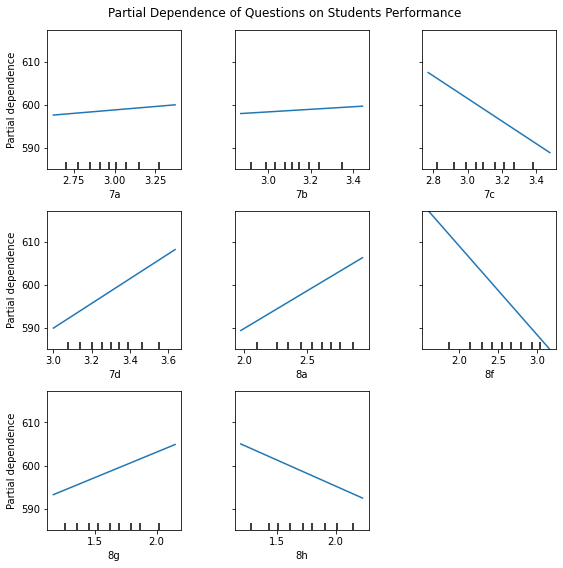

In [113]:
plot_partial_dependence(lr_safe, X_safe, list(X_safe.columns), grid_resolution=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
fig.suptitle('Partial Dependence of Questions on Students Performance')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.tight_layout()
fig.savefig('../assets/partical_dependence_linear.png', bbox_inches='tight');

In [116]:
scores

,model,r2,adjusted_r2,mse
0,null,-0.005951,-0.947001,139.820626
1,linear_all,0.805202,0.622972,27.075655
2,pca_linear,0.704574,0.677717,41.062252
3,linear_reduced,0.794534,0.632000,22.398452
4,ridge,0.796656,0.635801,22.167100
5,top3_linear,0.375767,0.359761,75.965565
6,safe_lr,0.573561,0.543102,59.272193


In [124]:
reduced_scores = scores.iloc[[0, 1, 2, 5, 6], :]

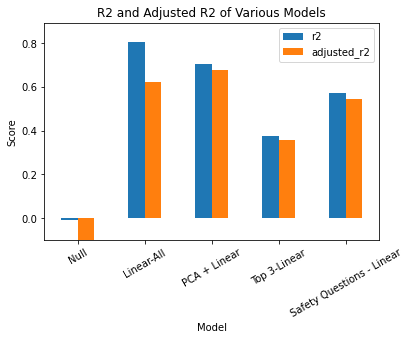

In [140]:
# plot scores
reduced_scores.plot.bar(x='model', y=['r2', 'adjusted_r2'])
plt.ylim(bottom=-0.1)
plt.xticks(ticks=range(5), labels=['Null', 'Linear-All', 'PCA + Linear','Top 3-Linear', 'Safety Questions - Linear'], rotation=30)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('R2 and Adjusted R2 of Various Models')
plt.savefig('../assets/reduced_models_r2_scores.png', bbox_inches='tight');

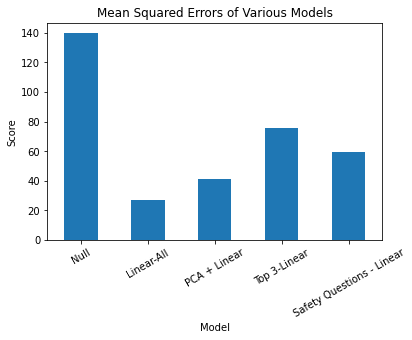

In [139]:
reduced_scores.plot.bar(x='model', y=['mse'], legend=None)
plt.ylim(bottom=-0.1)
plt.xticks(ticks=range(5), labels=['Null', 'Linear-All', 'PCA + Linear','Top 3-Linear', 'Safety Questions - Linear'], rotation=30)
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Mean Squared Errors of Various Models')
plt.savefig('../assets/reduced_models_mse.png', bbox_inches='tight');